# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Евстифеев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \dots $$

## Имплементация (5 баллов)

In [334]:
#%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, batch_size=32, alpha=0.01, max_epoch=10, verbose=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.minibatch_size = batch_size
        self.weights = None
        self.alphas = None
        self.log_loss = None
        self.threashold = 0.5
        self.verbose = verbose
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = self.__add_bias(X)
        self.weights = np.zeros(X.shape[1])
        self.log_loss = np.empty(self.max_epoch)
        for i in range(self.max_epoch):
            alpha = self.__exp_learning_rate(i) # Alpha decay
            permutations = np.random.permutation(X.shape[0])
            X_shuffled = X[permutations]
            y_shuffled = y[permutations]
            a_full = self.__sigmoid(np.dot(X_shuffled, self.weights))
            loss = self.__log_loss(a_full, y_shuffled)
            if self.verbose and i % 2 == 0:
                print("Loss on {0} epoch: {1}".format(i, loss))
            self.log_loss[i] = loss
            for j in range(0, X.shape[0], self.minibatch_size):
                X_batch = X_shuffled[j:j + self.minibatch_size]
                y_batch = y_shuffled[j:j + self.minibatch_size]
                m = X_batch.shape[0]
                a = self.__sigmoid(np.dot(X_batch, self.weights))
                weight_without_bias = self.weights.copy()
                weight_without_bias[0] = 0
                gradients = (1./m) * np.dot(X_batch.T, (a - y_batch)) + (self.C / m) * weight_without_bias
                #print("GRADIENTS: ", gradients)
                self.weights -= alpha * gradients
        return self
    
    def __exp_learning_rate(self, iter_num, k=0.1):
        return self.alpha * np.exp(-k*iter_num)
    
    def __log_loss(self, a, y):
        m = y.size
        return -1 * (1. / m) * np.sum(y * np.log(a) + (1 - y) * np.log(1 - a)) \
               + (self.C / (2. * m)) * np.sum(self.weights[1:]**2)
    
    def __sigmoid(self, a):
        return 1./(1 + np.exp(-a))
    
    def __add_bias(self, X):
        bias = np.ones((X.shape[0], 1))
        return np.hstack((bias, X))
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = self.__add_bias(X)
        y_hat = (self.__sigmoid(np.dot(X, self.weights))) >= self.threashold
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = self.__add_bias(X)
        y_hat_proba_plus = self.__sigmoid(np.dot(X, self.weights))
        y_hat_proba_minus = 1 - y_hat_proba_plus
        y_hat_proba = np.vstack((y_hat_proba_minus, y_hat_proba_plus, )).T
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

Weights:  [-4.20518855  0.96547355 -0.92836513]


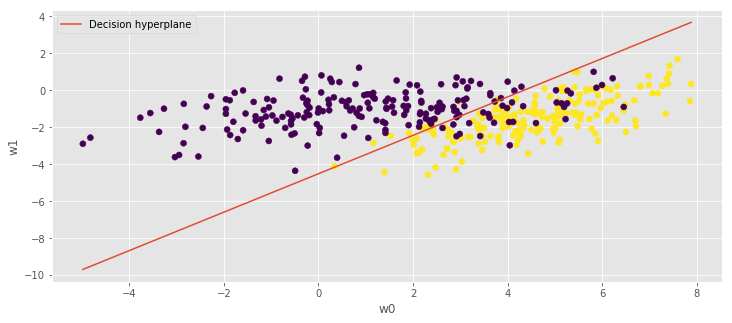

In [321]:
from sklearn.metrics import roc_auc_score
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)
X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(max_epoch=300, alpha=1, batch_size=32, verbose=False)
clf.fit(X, y)
print("Weights: ", clf.weights)
#print(roc_auc_score(clf.predict(X), y))
# plot hyperplane
x = np.linspace(X.min(), X.max(), 2)
Y = -(clf.weights[0] + clf.weights[1]*x)/clf.weights[2]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x, Y, label="Decision hyperplane")
plt.xlabel('w0')
plt.ylabel('w1')
plt.legend()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [297]:
from sklearn.datasets import make_classification
import seaborn

In [298]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

CURRENT ALPHA: 0.01
CURRENT ALPHA: 0.1
CURRENT ALPHA: 0.3
CURRENT ALPHA: 0.5
CURRENT ALPHA: 0.7
CURRENT ALPHA: 1
CURRENT ALPHA: 5
CURRENT ALPHA: 7
CURRENT ALPHA: 10


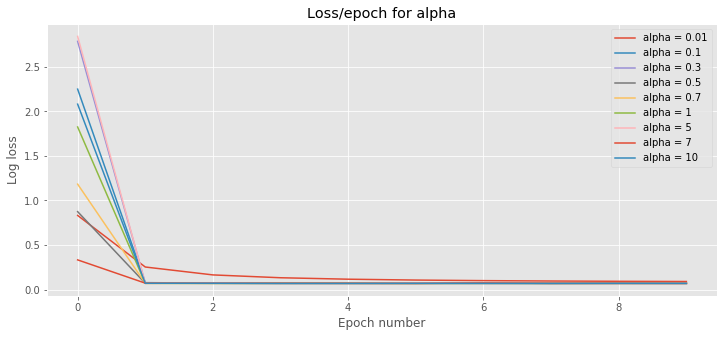

In [299]:
alphas = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 5, 7, 10]
for alpha in alphas:
    print("CURRENT ALPHA: {0}".format(alpha))
    clf = MySGDClassifier(alpha=alpha, max_epoch=10, verbose=False, batch_size=200)
    clf.fit(X, y)
    plt.plot(clf.log_loss, label = "alpha = " + str(alpha))
plt.title('Loss/epoch for alpha')
plt.xlabel('Epoch number')
plt.ylabel('Log loss')
plt.legend()
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

Current C: 1000.0
Current C: 215.44346900318845
Current C: 46.4158883361278
Current C: 10.0
Current C: 2.1544346900318843
Current C: 0.4641588833612782
Current C: 0.1
Current C: 0.021544346900318867
Current C: 0.004641588833612782
Current C: 0.001


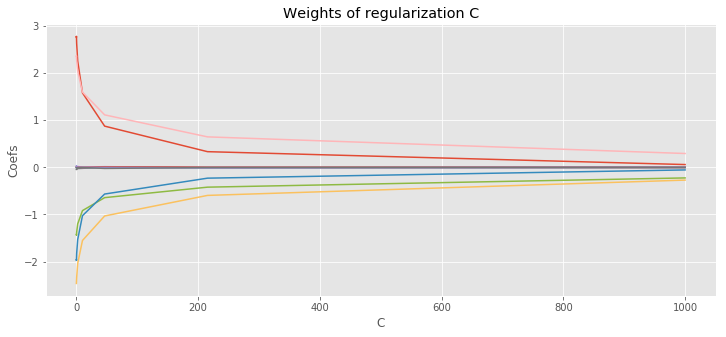

In [301]:
Cs = np.logspace(3, -3, 10)
weights = []
for C in Cs:
    print("Current C: {0}".format(C))
    clf = MySGDClassifier(C=C, alpha=1, max_epoch=10, batch_size=1000, verbose=False)
    clf.fit(X, y)
    weights.append(clf.weights)
plt.plot(Cs, weights)
plt.title('Weights of regularization C')
plt.xlabel('C')
plt.ylabel('Coefs')
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [418]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './data/trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [419]:
df_data.shape

(500000, 45)

In [420]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [421]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [422]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [423]:
# Задание №1
print("Количество уникальных карт героя у игрока = {0}".format(df_data['player_hero_card_id'].nunique()))
print("Количество уникальных карт героя у оппонента = {0}".format(df_data['opponent_hero_card_id'].nunique()))

Количество уникальных карт героя у игрока = 9
Количество уникальных карт героя у оппонента = 9


In [425]:
# Задание №2
def encode_dataframe(df_data_, columns_=None):
    one_hot_columns = []
    df_data_new = df_data_.copy(deep=True)
    for column in df_data_.columns:
        if columns_ is not None and column not in columns_:
            continue
        unique_column_values = df_data_[column].nunique()
        if unique_column_values < 10 and unique_column_values > 2:
            dummies = pd.get_dummies(df_data_[column], prefix=column)
            df_data_new = pd.concat([df_data_new, dummies], axis=1)
            df_data_new = df_data_new.drop(columns=[column])
            one_hot_columns.append(column)
    return df_data_new, one_hot_columns
df_data_encoded, one_hot_columns = encode_dataframe(df_data)

In [426]:
one_hot_columns

['opponent_attack',
 'opponent_hero_card_id',
 'opponent_weapon_durability',
 'opponent_fatigue_damage',
 'opponent_played_minions_count',
 'player_attack',
 'player_hero_card_id',
 'player_weapon_durability',
 'player_fatigue_damage',
 'player_played_minions_count',
 'opponent_played_nOfCards',
 'player_played_nOfCards',
 'player_hand_nOfSpells',
 'player_hand_nOfWeapons']

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [427]:
# Задание №3
X = df_data_encoded.drop(columns=['decision']).astype('float32')
y = df_data_encoded['decision']
X.shape

(500000, 129)

In [ ]:
# Задание №4
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('std', StandardScaler()), 
                 ('clf', MySGDClassifier(C=20, batch_size=100000, alpha=1, verbose=True, max_epoch=1000))])
pipe.fit(X.values, y.values)

Loss on 0 epoch: 0.6931471805599451
Loss on 2 epoch: 0.5770177397977242
Loss on 4 epoch: 0.552844873885357


In [429]:
roc_auc_score(pipe.predict(X.values), y.values)

0.7001394017289617

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [484]:
# Задание №6
test_file_path = './data/deprecated_testData_tabular/testData_tabular_chunk5.csv'
test_data = pd.read_csv(test_file_path, sep=',')
y_test = pd.read_csv('./data/deprecated_testLabels.txt', header=None)[:500000]
test_data.columns = test_data.columns.str.replace('.', '_')
test_data['decision'] = y_test 
test_data = test_data.set_index('gamestate_id')
test_data = test_data[test_data['player_fatigue_damage'] != 6]
y_test = test_data['decision']
test_data = test_data.drop(columns='decision')
test_data_encoded = encode_dataframe(test_data, one_hot_columns)[0].astype('float32')

In [485]:
z = set(X.columns)
x = set(test_data_encoded.columns)
x - z

set()

In [486]:
[i for i in test_data_encoded.columns if i.startswith("player_fatigue_damage")]

['player_fatigue_damage_0',
 'player_fatigue_damage_1',
 'player_fatigue_damage_2',
 'player_fatigue_damage_3',
 'player_fatigue_damage_4',
 'player_fatigue_damage_5']

In [487]:
[i for i in X.columns if i.startswith("player_fatigue_damage")]
test_data_encoded.shape, y_test.shape

((499997, 129), (499997,))

In [488]:
roc_auc_score(pipe.predict(test_data_encoded.values), y_test)

0.7011982764505926